# Peter ve Kurt: Gerçekçi Bir Çevre

Bizim senaryomuzda, Peter neredeyse hiç yorulmadan ya da acıkmadan dolaşabiliyordu. Daha gerçekçi bir dünyada, zaman zaman oturup dinlenmesi ve kendini beslemesi gerekir. Dünyamızı daha gerçekçi hale getirelim ve şu kuralları uygulayalım:

1. Bir yerden başka bir yere hareket ettiğinde, Peter **enerji** kaybeder ve biraz **yorgunluk** kazanır.
2. Peter, elma yiyerek daha fazla enerji kazanabilir.
3. Peter, bir ağacın altında ya da çimenlerin üzerinde dinlenerek yorgunluğunu atabilir (yani, bir ağaç ya da çimen bulunan bir tahtanın konumuna yürüyerek - yeşil alan).
4. Peter, kurdu bulmalı ve öldürmelidir.
5. Kurdu öldürmek için, Peter'ın belirli bir enerji ve yorgunluk seviyesine sahip olması gerekir, aksi takdirde savaşı kaybeder.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

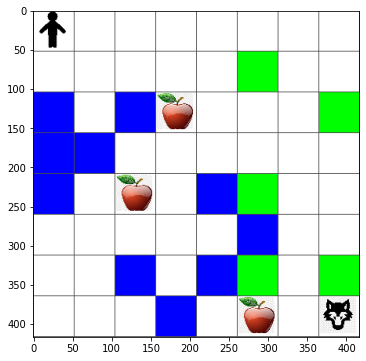

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Durum Tanımlama

Yeni oyun kurallarımızda, her bir tahta durumunda enerji ve yorgunluğu takip etmemiz gerekiyor. Bu nedenle, mevcut problem durumuyla ilgili tüm gerekli bilgileri taşıyacak bir `state` nesnesi oluşturacağız. Bu bilgiler arasında tahtanın durumu, mevcut enerji ve yorgunluk seviyeleri ve terminal durumdayken kurdu yenip yenemeyeceğimiz yer alacak:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Hadi rastgele yürüyüş kullanarak problemi çözmeyi deneyelim ve başarılı olup olmadığımızı görelim:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Ödül Fonksiyonu

### Amaç
Bu bölümde, bir ödül fonksiyonunun nasıl oluşturulacağını ve bu fonksiyonun bir modelin performansını optimize etmek için nasıl kullanılacağını öğreneceksiniz.

### Ödül Fonksiyonu Nedir?
Ödül fonksiyonu, bir modelin belirli bir görevi ne kadar iyi yerine getirdiğini ölçmek için kullanılan bir metrik sağlar. Modelin çıktısını değerlendirir ve bir "ödül" değeri döndürür. Bu değer, modelin öğrenme sürecinde yönlendirilmesine yardımcı olur.

### Ödül Fonksiyonu Nasıl Çalışır?
1. **Girdi:** Modelin tahminleri ve gerçek değerler.
2. **İşlem:** Tahminler ile gerçek değerler arasındaki farkı hesaplar.
3. **Çıktı:** Modelin performansını temsil eden bir ödül değeri.

### Örnek
Aşağıda basit bir ödül fonksiyonu örneği verilmiştir:

```python
def reward_function(predictions, actuals):
    # Tahminler ile gerçek değerler arasındaki farkı hesapla
    error = abs(predictions - actuals)
    # Hata ne kadar küçükse ödül o kadar büyük
    reward = 1 / (1 + error)
    return reward
```

### İyi Bir Ödül Fonksiyonu Tasarlama
İyi bir ödül fonksiyonu tasarlarken aşağıdaki noktaları göz önünde bulundurun:
- **Hedefe Uygunluk:** Ödül fonksiyonu, modelin optimize etmeye çalıştığı hedefle uyumlu olmalıdır.
- **Hassasiyet:** Küçük performans değişikliklerini ayırt edebilmelidir.
- **Denge:** Modeli aşırı uyumdan kaçınmaya teşvik etmelidir.

### Yaygın Hatalar
- **Aşırı Karmaşıklık:** Ödül fonksiyonunu gereksiz yere karmaşık hale getirmek, modelin öğrenme sürecini zorlaştırabilir.
- **Yanlılık:** Ödül fonksiyonunun belirli bir tür tahmini veya davranışı ödüllendirmesi, modelin dengesiz sonuçlar üretmesine neden olabilir.

### Sonuç
Ödül fonksiyonu, modelin performansını optimize etmek için kritik bir bileşendir. İyi tasarlanmış bir ödül fonksiyonu, modelin doğru ve etkili bir şekilde öğrenmesine yardımcı olur.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Öğrenme algoritması

Gerçek öğrenme algoritması neredeyse hiç değişmez, sadece tahta pozisyonu yerine `state` kullanırız.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

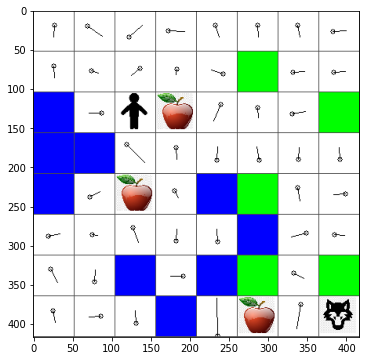

In [11]:
m.plot(Q)

## Sonuçlar

Peter'i kurda karşı savaşması için eğitmede başarılı olup olmadığımızı görelim!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Artık çok daha az boğulma vakası görüyoruz, ancak Peter hala her zaman kurdu öldüremiyor. Hiperparametrelerle oynayarak bu sonucu iyileştirip iyileştiremeyeceğinizi denemeye çalışın.


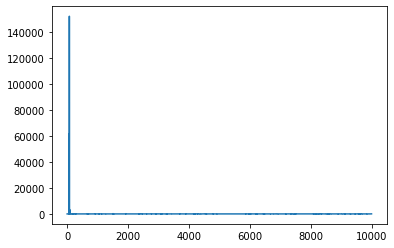

In [13]:
plt.plot(lpath)


---

**Feragatname**:  
Bu belge, AI çeviri hizmeti [Co-op Translator](https://github.com/Azure/co-op-translator) kullanılarak çevrilmiştir. Doğruluğu sağlamak için çaba göstersek de, otomatik çevirilerin hata veya yanlışlık içerebileceğini lütfen unutmayın. Belgenin orijinal dili, yetkili kaynak olarak kabul edilmelidir. Kritik bilgiler için profesyonel insan çevirisi önerilir. Bu çevirinin kullanımından kaynaklanan yanlış anlamalar veya yanlış yorumlamalar için sorumluluk kabul etmiyoruz.
